# Two-step curve fitting for downstream task scores

24 September 2024

### Step 1

In step 1, we map the (N, D) to task loss (bpb loss). We use only the final checkpoints for this prediction.

### Step 2

In step 2, we map the predicted task bpb loss to task scores. The fitting function is taken to be a reverse sigmoid function (low bpb loss on the left indicates higher task score). This is inspired from the llama3.1 paper, and can be intuitively explained as follows: 
* As the model starts to learn, the initial high bpb loss values correspond to random performance (accuracy = 0.25).
* As the model improves, the loss decreases and the scores increase.
* At some point, the model reaches saturation on the task, and any loss values within a small enough range correspond to highest possible score for that task (accuracy = 1.0).

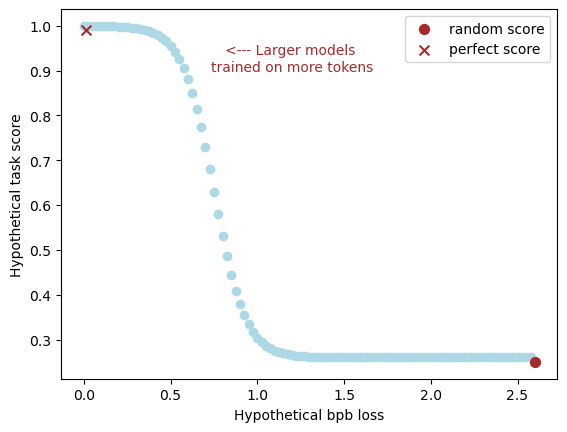

In [239]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x, L, x0, k, b):
    o = L / (1 + np.exp(- k * (x - x0))) + b
    return (o)

plt.figure()
x = np.arange(0, 2.6, 0.025)
y = [sigmoid(x_, -0.74, 0.75, 11, 1) for x_ in x]
plt.scatter(x, y, color="lightblue")
plt.scatter(2.6, 0.25, label="random score", color="brown", s=50)
plt.scatter(0.01, 0.99, label="perfect score", color="brown", marker="x", s=50)

plt.annotate(
    "<--- Larger models \ntrained on more tokens",
    (1.2, 0.9),
    textcoords="offset points",
    xytext=(0, 0),
    ha="center",
    fontsize=10,
    color="brown",
)

plt.xlabel("Hypothetical bpb loss")
plt.ylabel("Hypothetical task score")
plt.legend(loc="upper right", ncols=1)
plt.show()

**Trick 1: We add 2 extra points based on the following assumptions as a sanity check:**
* For every task, the lowest possible bpb loss = 0.01, which corresponds to task score = 1.0 (perfect score).
* For every task, the highest possible bpb loss = 2.6, which corresponds to a task score = 0.25 (random score). This bpb value is somewhat arbitrarily chosen after eyeballing the bpb values of all the tasks.
* This also helps avoid the rare cases when the fitting function degenerates for very noisy data.
* We can be a bit smarter about picking different "ideal" values for each task, based on task knowledge, but the above assumptions seem good enough for the most part.

**Trick 2: Use the moving average of bpb loss to map to the task score, instead of raw bpb scores.**
* I have picked window size = 20 (the smallest model has only 20 eval points, so a larger window size will lead to loss of points for that model).
* We can pick a different window size per task (I tried out a few random values, and it did improve the relative error a little bit), but it is not clear what is the "ideal" window size.

**Trick 3: Use exponential moving average of bpb loss to map to the task score, instead of raw bpb scores.**
* I have picked alpha = 0.5.
* Tried with alpha = 0.7, 0.9 as well. Different tasks exhibit different results.

**Trick 4: Instead of all the bpb to score pairs, only use the last n% points per run.**
* I have chosen 2%.

### Other notes
* For aggregate findings below, I have removed boolq due to extremely noisy error rates.

In [220]:
%%html
<style>
  table {
    width: 75%;
    text-align: left;
  }
</style>

## Findings

### Easy setting (use every run in the ladder upto the target run): 

| Target model | Uses |
| --- | --- |
| 3B-1xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC, 10xC)<br>530M-(1xC, 2xC, 5xC, 10xC)<br>750M-(1xC, 2xC, 5xC, 10xC)<br>1B-(1xC, 2xC, 5xC, 10xC) |
| 3B-2xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC, 10xC)<br>530M-(1xC, 2xC, 5xC, 10xC)<br>750M-(1xC, 2xC, 5xC, 10xC)<br>1B-(1xC, 2xC, 5xC, 10xC)<br>3B-(1xC) |
| 3B-5xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC, 10xC)<br>530M-(1xC, 2xC, 5xC, 10xC)<br>750M-(1xC, 2xC, 5xC, 10xC)<br>1B-(1xC, 2xC, 5xC, 10xC)<br>3B-(1xC, 2xC) |

<br>


| Task | Stacked error (3B-1xC) | Stacked error (3B-2xC) | Stacked error (3B-5xC) |
| --- | --- | --- | --- |
| MMLU-Var |+4.7% |-1.6% |-0.9% |
| HellaSwag-5shot |+6.2% |-0.6% |+2.6% |
| ARC-Easy-5shot |+3.8% |-2.6% |-4.6% |
| ARC-Challenge-5shot |+2.5% |-7.6% |+4.3% |
| PiQA-5shot |-0.4% |-1.5% |-1.9% |
| Winogrande-5shot |+3.2% |+4.0% |+2.8% |
| OpenbookQA-5shot |-1.3% |+2.9% |+5.0% |
| SciQ-0shot |-0.6% |-2.1% |-2.3% |
| CSQA-5shot |+3.4% |+1.5% |+1.9% |
| SocialIQA-5shot |+6.1% |-1.6% |-3.8% |
| **Avg signed error** | **+2.8%** |**-0.9%** |**+0.3%** |
| **Avg unsigned error** | **+3.2%** |**+2.6%** |**+3.0%** |



### Harder setting (using models with 1/10th the number of training tokens):


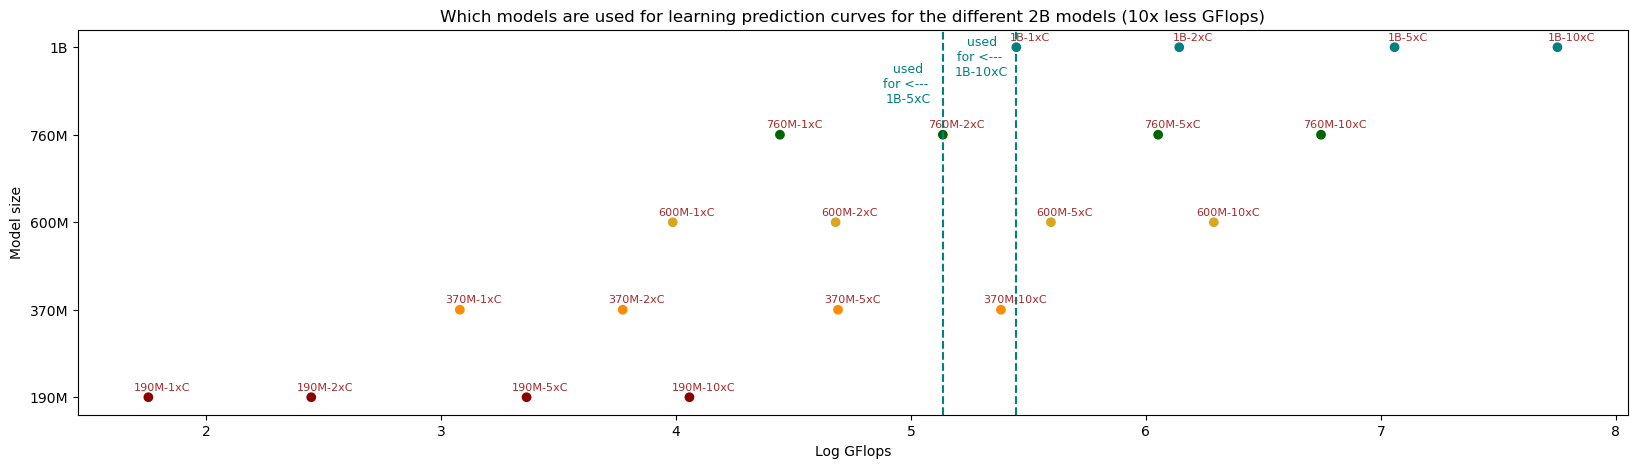

In [221]:
import ladder_peteish as ladder
import pandas as pd

all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))

sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
sorted_by_flops

## I'm using generous upper-bounds here to find the nearest corresponding run

corresponding_flops_10x = {
    "1B-5xC": "760M-2xC",
    "1B-10xC": "1B-1xC",
}


tups = [(tup[0].split("-")[0], tup[0].split("-")[1], tup[1]) for tup in sorted_by_flops]

color_map = {
    "190M": "darkred",
    "370M": "darkorange",
    "600M": "goldenrod",
    "760M": "darkgreen",
    "1B": "teal",
    # "3B": "darkmagenta",
    #"7B":
}

ladder_df = pd.DataFrame(tups, columns=["size", "length", "gflops"])
ladder_df["color"] = ladder_df.apply(lambda x: color_map[x["size"]], axis=1)
#ladder_df["color"] = ladder_df.apply(lambda x: length_colors[x["length"]], axis=1)
ladder_df["label"] = ladder_df.apply(lambda x: f"{x['size']}-{x['length']}", axis=1)
ladder_df["log_gflops"] = ladder_df.apply(lambda x: np.log(x['gflops']), axis=1)
ladder_df["dot_size"] = ladder_df.apply(lambda x: 72 if x['size'] == '3B' else 36, axis=1)

fig = plt.figure(figsize=(20, 5))
ax = plt.gca()

for label in ladder_df["size"].unique():
    adf = ladder_df[ladder_df["size"]==label]
    ax.scatter(adf["log_gflops"], adf["size"], color=adf["color"], s=adf["dot_size"], label=adf["label"])

for _, row in ladder_df.iterrows():
    ax.annotate(
        f"{row['label']}",
        (row['log_gflops'], row['size']),
        textcoords="offset points",
        xytext=(10, 5),
        ha="center",
        fontsize=8,
        color="brown",
    )

y_loc = -40
for key, val in corresponding_flops_10x.items():
    row = ladder_df[ladder_df["label"] == val].iloc[0]
    ax.axvline(x = row["log_gflops"], color=color_map["1B"], label = row["label"], linestyle='--')
    ax.annotate(
        f"used\nfor <--- \n{key}",
        (row['log_gflops'], "1B"),
        textcoords="offset points",
        xytext=(-25, y_loc),
        ha="center",
        fontsize=9,
        color=color_map["1B"],
    )
    if y_loc == -40:
        y_loc = -20
    else:
        y_loc = -40

ax.set_xlabel("Log GFlops")
ax.set_ylabel("Model size")
ax.set_title("Which models are used for learning prediction curves for the different 2B models (10x less GFlops)")
plt.show()


| Target model | Uses |
| --- | --- |
| 3B-1xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC)<br>530M-(1xC, 2xC)<br>750M-(1xC, 2xC)<br> |
| 3B-2xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC, 10xC)<br>530M-(1xC, 2xC, 5xC)<br>750M-(1xC, 2xC)<br>1B-(1xC) |
| 3B-5xC | 150M-(1xC, 2xC, 5xC, 10xC)<br>300M-(1xC, 2xC, 5xC, 10xC)<br>530M-(1xC, 2xC, 5xC, 10xC)<br>750M-(1xC, 2xC, 5xC, 10xC)<br>1B-(1xC, 2xC) |


<br>

| Task | Stacked error (3B-1xC) | Stacked error (3B-2xC) | Stacked error (3B-5xC) |
| --- | --- | --- | --- |
| MMLU-Var |-1.3% |-3.8% |+0.1% |
| HellaSwag-5shot |-1.2% |-2.9% |+4.5% |
| ARC-Easy-5shot |-2.5% |-5.5% |-4.4% |
| ARC-Challenge-5shot |+74.2% |+7.6% |+11.9% |
| PiQA-5shot |+0.6% |-2.0% |-1.8% |
| Winogrande-5shot |+25.1% |+9.6% |+4.4% |
| OpenbookQA-5shot |+27.3% |+15.2% |-6.6% |
| SciQ-0shot |-4.3% |-4.7% |-4.5% |
| CSQA-5shot |+4.1% |+5.9% |+7.3% |
| SocialIQA-5shot |-3.6% |-1.1% |-2.6% |
| **Avg signed error** | **+11.8%** |**+1.8%** |**+0.8%** |
| **Avg unsigned error** | **+14.4%** |**+5.8%** |**+4.8%** |

## Download W&B logs

In [222]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from argparse import Namespace
import os

In [11]:
WANDB_RESULTS = "wandb/peteish-final-backfill3"
FIGURES = "figures"

In [224]:
def get_name_size_length(run_name: str):
    run_name = run_name.split("/")[-1]
    size, length = run_name.split("-")[-2:]
    return run_name, size, length

In [264]:
import itertools
run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

#run_names.append("ai2-llm/olmo-medium/peteish7")

validation_outputs = {}

for run_name in run_names:

    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}-steps.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
        eval_only=False
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/qy52m4xu (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-190M-1xC


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/1bi2rxj6 (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-190M-2xC


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 6 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/pqtzktvm (crashed)>
<Run ai2-llm/olmo-ladder/cyvn3fiv (crashed)>
<Run ai2-llm/olmo-ladder/ndyrz8a6 (failed)>
<Run ai2-llm/olmo-ladder/2b0e1vp2 (failed)>
<Run ai2-llm/olmo-ladder/xroyqg4r (failed)>
<Run ai2-llm/olmo-ladder/qupmao8q (finished)>


  0%|          | 0/6 [00:00<?, ?it/s]

Processing peteish-final-190M-5xC


 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

Processing peteish-final-190M-5xC


 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

Processing peteish-final-190M-5xC
Processing peteish-final-190M-5xC


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

Processing peteish-final-190M-5xC
Processing peteish-final-190M-5xC


100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


Found 4 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/mjxwck9p (crashed)>
<Run ai2-llm/olmo-ladder/bpw4qfcj (crashed)>
<Run ai2-llm/olmo-ladder/fadti1op (crashed)>
<Run ai2-llm/olmo-ladder/c4k7jky7 (finished)>


  0%|          | 0/4 [00:00<?, ?it/s]

Processing peteish-final-190M-10xC


 25%|██▌       | 1/4 [00:00<00:01,  1.51it/s]

Processing peteish-final-190M-10xC


 50%|█████     | 2/4 [00:02<00:02,  1.14s/it]

Processing peteish-final-190M-10xC


 75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

Processing peteish-final-190M-10xC


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/i7xi9dr6 (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-370M-1xC


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/mja2yxtn (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-370M-2xC


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Found 4 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/h2zkd73d (crashed)>
<Run ai2-llm/olmo-ladder/v1zu9ot9 (crashed)>
<Run ai2-llm/olmo-ladder/d3ppuub9 (crashed)>
<Run ai2-llm/olmo-ladder/rw0sxo3q (finished)>


  0%|          | 0/4 [00:00<?, ?it/s]

Processing peteish-final-370M-5xC


 25%|██▌       | 1/4 [00:01<00:04,  1.52s/it]

Processing peteish-final-370M-5xC


 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]

Processing peteish-final-370M-5xC


 75%|███████▌  | 3/4 [00:05<00:01,  1.83s/it]

Processing peteish-final-370M-5xC


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Found 7 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/zjk54j54 (crashed)>
<Run ai2-llm/olmo-ladder/bcqyxbsb (crashed)>
<Run ai2-llm/olmo-ladder/m4fcri1h (crashed)>
<Run ai2-llm/olmo-ladder/b7qavi4u (crashed)>
<Run ai2-llm/olmo-ladder/4fous2ud (crashed)>
<Run ai2-llm/olmo-ladder/twioudlw (failed)>
<Run ai2-llm/olmo-ladder/v8ntjs37 (finished)>


  0%|          | 0/7 [00:00<?, ?it/s]

Processing peteish-final-370M-10xC


 14%|█▍        | 1/7 [00:01<00:10,  1.80s/it]

Processing peteish-final-370M-10xC


 29%|██▊       | 2/7 [00:03<00:07,  1.53s/it]

Processing peteish-final-370M-10xC


 57%|█████▋    | 4/7 [00:05<00:03,  1.05s/it]

Processing peteish-final-370M-10xC
Processing peteish-final-370M-10xC


 86%|████████▌ | 6/7 [00:05<00:00,  1.78it/s]

Processing peteish-final-370M-10xC
Processing peteish-final-370M-10xC


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/ogegzz9e (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-600M-1xC


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/rfbztbxm (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-600M-2xC


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/5at0240v (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-600M-5xC


100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/wwpfo8co (crashed)>
<Run ai2-llm/olmo-ladder/35smpoj0 (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-600M-10xC


 50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

Processing peteish-final-600M-10xC


100%|██████████| 2/2 [00:18<00:00,  9.29s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/yepm704f (crashed)>
<Run ai2-llm/olmo-ladder/g1j69u8k (finished)>


 50%|█████     | 1/2 [00:00<00:00,  7.73it/s]

Processing peteish-final-760M-1xC
Processing peteish-final-760M-1xC


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Found 5 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/l7w1ue32 (crashed)>
<Run ai2-llm/olmo-ladder/0oaxgiqn (crashed)>
<Run ai2-llm/olmo-ladder/y0r0kpha (crashed)>
<Run ai2-llm/olmo-ladder/b5pk084a (crashed)>
<Run ai2-llm/olmo-ladder/dsny48o9 (finished)>


 20%|██        | 1/5 [00:00<00:00,  8.46it/s]

Processing peteish-final-760M-2xC
Processing peteish-final-760M-2xC


 80%|████████  | 4/5 [00:00<00:00,  8.74it/s]

Processing peteish-final-760M-2xC
Processing peteish-final-760M-2xC
Processing peteish-final-760M-2xC


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/0vxbrf1z (crashed)>
<Run ai2-llm/olmo-ladder/kloayi58 (finished)>


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]

Processing peteish-final-760M-5xC
Processing peteish-final-760M-5xC


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Found 4 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/8xfok3fl (crashed)>
<Run ai2-llm/olmo-ladder/wvkk4stp (crashed)>
<Run ai2-llm/olmo-ladder/nagmjno0 (failed)>
<Run ai2-llm/olmo-ladder/6nibgsau (finished)>


  0%|          | 0/4 [00:00<?, ?it/s]

Processing peteish-final-760M-10xC


 25%|██▌       | 1/4 [00:02<00:08,  2.86s/it]

Processing peteish-final-760M-10xC


 75%|███████▌  | 3/4 [00:03<00:00,  1.26it/s]

Processing peteish-final-760M-10xC
Processing peteish-final-760M-10xC


100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


Found 4 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/087ol2ri (crashed)>
<Run ai2-llm/olmo-ladder/hvmwi0np (crashed)>
<Run ai2-llm/olmo-ladder/6k30g8by (crashed)>
<Run ai2-llm/olmo-ladder/apd9qqto (finished)>


  0%|          | 0/4 [00:00<?, ?it/s]

Processing peteish-final-1B-1xC


 50%|█████     | 2/4 [00:01<00:00,  2.05it/s]

Processing peteish-final-1B-1xC
Processing peteish-final-1B-1xC
Processing peteish-final-1B-1xC


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Found 5 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/27wcmatq (crashed)>
<Run ai2-llm/olmo-ladder/y96u31hz (crashed)>
<Run ai2-llm/olmo-ladder/qhvj7xcx (crashed)>
<Run ai2-llm/olmo-ladder/okm5na9k (failed)>
<Run ai2-llm/olmo-ladder/91s2an11 (finished)>


  0%|          | 0/5 [00:00<?, ?it/s]

Processing peteish-final-1B-2xC


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

Processing peteish-final-1B-2xC


 60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

Processing peteish-final-1B-2xC


 80%|████████  | 4/5 [00:02<00:00,  2.51it/s]

Processing peteish-final-1B-2xC
Processing peteish-final-1B-2xC


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/uytzp23g (crashed)>
<Run ai2-llm/olmo-ladder/yadcj94x (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-1B-5xC


 50%|█████     | 1/2 [00:00<00:00,  1.03it/s]

Processing peteish-final-1B-5xC


100%|██████████| 2/2 [00:15<00:00,  7.94s/it]


Found 8 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/r0sviuka (crashed)>
<Run ai2-llm/olmo-ladder/0n980y0g (crashed)>
<Run ai2-llm/olmo-ladder/1fdoq5a6 (crashed)>
<Run ai2-llm/olmo-ladder/ve23htwz (failed)>
<Run ai2-llm/olmo-ladder/o3u8ggga (crashed)>
<Run ai2-llm/olmo-ladder/iio4vz7w (crashed)>
<Run ai2-llm/olmo-ladder/bxba4yzk (crashed)>
<Run ai2-llm/olmo-ladder/xnuxszwk (finished)>


  0%|          | 0/8 [00:00<?, ?it/s]

Processing peteish-final-1B-10xC


 12%|█▎        | 1/8 [00:07<00:49,  7.08s/it]

Processing peteish-final-1B-10xC


 38%|███▊      | 3/8 [00:20<00:28,  5.76s/it]

Processing peteish-final-1B-10xC
Processing peteish-final-1B-10xC


 62%|██████▎   | 5/8 [00:20<00:06,  2.33s/it]

Processing peteish-final-1B-10xC
Processing peteish-final-1B-10xC


 75%|███████▌  | 6/8 [00:28<00:08,  4.17s/it]

Processing peteish-final-1B-10xC


 88%|████████▊ | 7/8 [00:36<00:05,  5.69s/it]

Processing peteish-final-1B-10xC


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


In [ ]:
import itertools
run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}-backfill3"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

#run_names.append("ai2-llm/olmo-medium/peteish7")

validation_outputs = {}

for run_name in run_names:

    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name.removesuffix("-backfill3"))
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="_step",
        y_axis=["eval/validation-and-soft-and-downstream"],
        output_path=output_path,
        eval_only=True
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/tcnacq2w (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-190M-1xC-backfill3


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/cu9ruwib (crashed)>
<Run ai2-llm/olmo-ladder/7ndxb4cu (finished)>


 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]

Processing peteish-final-190M-2xC-backfill3
Processing peteish-final-190M-2xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/so9q32gr (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-190M-5xC-backfill3


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/8oyzrrxx (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-190M-10xC-backfill3


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/sdhrmj6c (crashed)>
<Run ai2-llm/olmo-ladder/oj7jb68s (finished)>


 50%|█████     | 1/2 [00:00<00:00,  7.11it/s]

Processing peteish-final-370M-1xC-backfill3
Processing peteish-final-370M-1xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/lih1xl99 (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-370M-2xC-backfill3


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/4kawzewj (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-370M-5xC-backfill3


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/4rzfddpy (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-370M-10xC-backfill3


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/ees7f7cw (crashed)>
<Run ai2-llm/olmo-ladder/5re0sb5y (finished)>


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]

Processing peteish-final-600M-1xC-backfill3
Processing peteish-final-600M-1xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/822jlbqv (crashed)>
<Run ai2-llm/olmo-ladder/x40uvrxf (finished)>


 50%|█████     | 1/2 [00:00<00:00,  5.16it/s]

Processing peteish-final-600M-2xC-backfill3
Processing peteish-final-600M-2xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/84x6e5bz (crashed)>
<Run ai2-llm/olmo-ladder/gs1pk5f0 (finished)>


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]

Processing peteish-final-600M-5xC-backfill3
Processing peteish-final-600M-5xC-backfill3


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/kjhsp99n (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-600M-10xC-backfill3


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/290ackc2 (crashed)>
<Run ai2-llm/olmo-ladder/3ctyae9q (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-760M-1xC-backfill3


 50%|█████     | 1/2 [00:00<00:00,  1.44it/s]

Processing peteish-final-760M-1xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/7iiesi7x (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-760M-2xC-backfill3


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/4ixww5fu (crashed)>
<Run ai2-llm/olmo-ladder/xs90netq (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-760M-5xC-backfill3


 50%|█████     | 1/2 [00:00<00:00,  1.46it/s]

Processing peteish-final-760M-5xC-backfill3


100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


Found 3 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/ydophm4d (crashed)>
<Run ai2-llm/olmo-ladder/xp7kfy61 (crashed)>
<Run ai2-llm/olmo-ladder/mw62m930 (finished)>


 33%|███▎      | 1/3 [00:00<00:00,  5.21it/s]

Processing peteish-final-760M-10xC-backfill3
Processing peteish-final-760M-10xC-backfill3


 67%|██████▋   | 2/3 [00:00<00:00,  5.44it/s]

Processing peteish-final-760M-10xC-backfill3


100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/y5c528n9 (crashed)>
<Run ai2-llm/olmo-ladder/gigt0a2h (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-1B-1xC-backfill3


 50%|█████     | 1/2 [00:01<00:01,  1.08s/it]

Processing peteish-final-1B-1xC-backfill3


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Found 1 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/wh69pbng (finished)>


  0%|          | 0/1 [00:00<?, ?it/s]

Processing peteish-final-1B-2xC-backfill3


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/pez4yudo (crashed)>
<Run ai2-llm/olmo-ladder/7c1g277m (finished)>


  0%|          | 0/2 [00:00<?, ?it/s]

Processing peteish-final-1B-5xC-backfill3
Processing peteish-final-1B-5xC-backfill3


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


Found 2 matching runs in ai2-llm/olmo-ladder
 <Run ai2-llm/olmo-ladder/3hoe3lt2 (crashed)>
<Run ai2-llm/olmo-ladder/uyooy532 (finished)>


 50%|█████     | 1/2 [00:00<00:00,  7.27it/s]

Processing peteish-final-1B-10xC-backfill3
Processing peteish-final-1B-10xC-backfill3


100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


In [266]:
validation_outputs

{'190M-1xC': 'wandb/peteish-final-backfill3/190M-1xC-steps.csv',
 '190M-2xC': 'wandb/peteish-final-backfill3/190M-2xC-steps.csv',
 '190M-5xC': 'wandb/peteish-final-backfill3/190M-5xC-steps.csv',
 '190M-10xC': 'wandb/peteish-final-backfill3/190M-10xC-steps.csv',
 '370M-1xC': 'wandb/peteish-final-backfill3/370M-1xC-steps.csv',
 '370M-2xC': 'wandb/peteish-final-backfill3/370M-2xC-steps.csv',
 '370M-5xC': 'wandb/peteish-final-backfill3/370M-5xC-steps.csv',
 '370M-10xC': 'wandb/peteish-final-backfill3/370M-10xC-steps.csv',
 '600M-1xC': 'wandb/peteish-final-backfill3/600M-1xC-steps.csv',
 '600M-2xC': 'wandb/peteish-final-backfill3/600M-2xC-steps.csv',
 '600M-5xC': 'wandb/peteish-final-backfill3/600M-5xC-steps.csv',
 '600M-10xC': 'wandb/peteish-final-backfill3/600M-10xC-steps.csv',
 '760M-1xC': 'wandb/peteish-final-backfill3/760M-1xC-steps.csv',
 '760M-2xC': 'wandb/peteish-final-backfill3/760M-2xC-steps.csv',
 '760M-5xC': 'wandb/peteish-final-backfill3/760M-5xC-steps.csv',
 '760M-10xC': 'wand

## Setup

In [1]:
import numpy as np
import pandas as pd
import ladder_peteish as ladder

import numpy as np
import matplotlib.pyplot as plt
from olmo.scaling.scaling_laws.utils import (
    get_coefficients_huber,
    chinchilla_n_d_fit,
    grad_chinchilla_n_d_fit,
    FinalConfig,
)

/Users/awettig/miniconda3/envs/olmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WANDB_RESULTS = "wandb/peteish-final-backfill3"
FIGURES = "figures"

In [3]:
from typing import Optional

def get_gflops(run_name: str, length_in_tokens: Optional[int] = None):
    run_name, size, length = get_name_size_length(run_name)
    length_in_tokens = length_in_tokens or ladder.parse_length(length, ladder.parse_size(size))
    flops = ladder.MODEL_GFLOPS[size]
    return flops * length_in_tokens / 1e9

def get_params(run_name: str):
    run_name, size, length = get_name_size_length(run_name)
    params = ladder.MODEL_PARAMS[size]
    return params

In [4]:
from collections import defaultdict
import csv

def get_all_data_by_name(configs, keys, negate=False):
    data_by_name = defaultdict(lambda: defaultdict(lambda: []))

    const = -1 if negate else 1

    if keys == ["throughput/total_tokens"]:
        for name, config in configs.items():
            for path in config.paths:
                with open(path.replace(".csv", "-steps.csv")) as file_ref:
                    reader = csv.DictReader(file_ref)
                    rows = [row for row in reader]
                    tokens_per_step = float(rows[0]["throughput/total_tokens"]) / int(rows[0]["_step"])

                with open(path) as file_ref:
                    reader = csv.DictReader(file_ref)
                    rows = [row for row in reader]
                    for row in rows:
                        if int(row["_step"]) > 0:
                            y = float(tokens_per_step * int(row["_step"]))
                            data_by_name[name][path].append(const * y)
    else:
        for name, config in configs.items():
            for path in config.paths:
                with open(path) as file_ref:
                    reader = csv.DictReader(file_ref)
                    rows = [row for row in reader]
                    for row in rows:
                        if int(row["_step"]) > 0:
                            y = np.mean([float(row[key]) for key in keys])
                            data_by_name[name][path].append(const * y)
    return data_by_name

In [5]:
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    o = L / (1 + np.exp(- k * (x - x0))) + b
    # o = - k * (x - x0) + b
    return (o)

def reverse_sigmoid(y, L, x0, k, b):
    return x0 - 1/k * np.log((L / (y - b)) -1)

# Error with using huber fit; possibly due to incorrect bounds (try later).

# def sigmoid_fit(x, p):
#     return p[0] / (1 + np.exp(-p[2] * (x - p[1]))) + p[3]

# def grad_sigmoid_fit(x, p):
#     grad_L = 1 / (1 + np.exp(-p[2] * (x - p[1])))
#     grad_x0 = p[0] * p[2] * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_k = p[0] * (x - p[1]) * sigmoid_fit(x, p) * (1 - sigmoid_fit(x, p))
#     grad_b = 1
#     return [grad_L, grad_x0, grad_k, grad_b]

# # fit the parameters
# coefficients = get_coefficients_huber(
#     train_nds,
#     train_ys,
#     sigmoid_fit,
#     grad_sigmoid_fit,
#     p0=[-1.3, 0.5, 3, 0.3],
#     bounds=None, #[(None, 0), (None, None), (None, None), (None, None)],
# )

In [6]:
def size_length_from_path(path):
    #wandb/amberish-rulebased/150M-1xC.csv
    name = path.split("/")[-1].strip(".csv")
    return name.split("-")[:2]

def get_dataframe(x_dict, y_dict):
    df = pd.DataFrame()
    xs = []
    ys = []
    params = []
    sizes = []
    lengths = []
    modes = []
    runs = []
    colors = []
    last_n_percent = []  # only use for step2
    for name, path_dict in x_dict.items():
        config = configs[name]
        for path in path_dict:
            size, length = size_length_from_path(path)
            run_name = f"{size}-{length}"
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            xs += x_data
            ys += y_data
            params += [config.n for _ in range(len(x_data))]
            sizes += [size for _ in range(len(x_data))]
            lengths += [length for _ in range(len(x_data))]
            modes += [config.mode for _ in range(len(x_data))]
            runs += [run_name for _ in range(len(x_data))]
            colors += [config.color for _ in range(len(x_data))]
            # last_n_percent += [config.use_last_n_percentage for _ in range(len(x_data))]
            last_n_percent += [0.02 for _ in range(len(x_data))]
    df["x"] = xs
    df["y"] = ys
    df["params"] = params
    df["size"] = sizes
    df["length"] = lengths
    df["mode"] = modes
    df["run"] = runs
    df["color"] = colors
    df["last_n_percent"] = last_n_percent
    return df

In [7]:
color_map = {
    "190M": "darkred",
    "370M": "darkorange",
    "600M": "goldenrod",
    "760M": "darkgreen",
    "1B": "teal",
    "7B": "darkmagenta",
}

pd.options.mode.chained_assignment = None

def get_predicted_error(df):
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    #rel_error = f"{rel_error * 100:+.1f}%"
    return rel_error

def fit_step1(df):
    df = df.dropna()

    # Fit
    train_nds = list(df[df["mode"]=="train"][["params", "x"]].itertuples(index=False, name=None))
    train_ys = df[df["mode"]=="train"]["y"]

    # fit the parameters
    coefficients = get_coefficients_huber(
        train_nds,
        train_ys,
        chinchilla_n_d_fit,
        grad_chinchilla_n_d_fit,
        p0=[3.0, 6.0, 0.1, 0.2, 1.0],
        bounds=[(0, None), (0, None), (0, None), (0, None), (0, None)],
        disp=False,
    )

    df["predicted_y"] = df.apply(lambda x: chinchilla_n_d_fit([x.params, x.x], coefficients), axis=1)
    return df, coefficients

def predict_step1(n, d, coefficients):
    return chinchilla_n_d_fit([n, d], coefficients)

def plot_step1(df, coefficients, ax, x_label=None, y_label=None, title="Fitting final score", do_label=True):

    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    run_name = eval_row["run"]

    for label in df["size"].unique():
        adf = df[df["size"]==label]
        ax.scatter(adf["x"], adf["y"], color="white", edgecolors=adf["color"], s=7.0, label=label if do_label else None)

    ax.scatter(x, y, marker="x", color="blue", label=f"actual ({run_name})= {y:0.4f}" if do_label else None, s=50)
    ax.scatter(x, y_pred, marker="^", color="black", label=f"predicted ({run_name}) = {y_pred:0.4}" if do_label else None, s=50)
    ax.annotate(
        f"{eval_row['run']}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(10, 5),
        ha="center",
        fontsize=10,
        color="brown",
    )

    for params in df["params"].unique():
        plotted_xs = np.linspace(df[df["params"]==params]["x"].max(), df[df["params"]==params]["x"].min(), 100)
        plotted_ys = [chinchilla_n_d_fit([params, x_val], coefficients) for x_val in plotted_xs]

        ax.plot(
            plotted_xs,
            plotted_ys,
            color="black",
            linestyle="--",
            linewidth=0.8,
        )

    # a, b, alpha, beta, E = coefficients
    # A, B = np.exp(a), np.exp(b)
    # ax.text(
    #     x=0.25,
    #     y=0.50,
    #     s=f"L(n, d) = {A:.2f} / n^{alpha:.2f} + {B:.2f} / d^{beta:.2f} + {E:.2f}",
    #     fontsize=10,
    #     transform=ax.transAxes,
    # )

    if do_label:
        ax.legend(loc="upper right", ncols=1)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

def fit_step2(df, baseline, add_ideal_points=True):
    df = df.dropna()

    # Fit

    train_xs = df[df["mode"]=="train"]["x"]
    train_ys = df[df["mode"]=="train"]["y"]

    if add_ideal_points:
        train_xs = pd.concat([pd.Series([0.01]), train_xs, pd.Series([train_xs.max()*2])], ignore_index=True)
        train_ys = pd.concat([pd.Series([1.0]), train_ys, pd.Series([baseline])], ignore_index=True)

    coefficients, pcov = curve_fit(sigmoid, train_xs, train_ys, p0=[baseline - 1.0, 0.9, 3.0, 1.0], maxfev=1000000)
    df["predicted_y"] = df["x"].apply(lambda x: sigmoid(x, *coefficients))

    return df, coefficients

def predict_step2(bpb_loss, coefficients):
    return sigmoid(bpb_loss, *coefficients)

def plot_step2(df, coefficients, ax, x_label=None, y_label=None, title="Fitting final score", add_ideal_points=True, do_label=True):

    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    run_name = eval_row["run"]

    for label in df["size"].unique():
        adf = df[df["size"]==label]
        ax.scatter(adf["x"], adf["y"], color="white", edgecolors=adf["color"], s=7.0, label=label if do_label else None)

    ax.scatter(x, y, marker="x", color="blue", label=f"actual ({run_name}) = {y:0.4f}" if do_label else None, s=50)
    ax.scatter(x, y_pred, marker="^", color="black", label=f"predicted ({run_name}) = {y_pred:0.4}" if do_label else None, s=50)
    ax.annotate(
        f"{eval_row['run']}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
        fontsize=10,
        color="brown",
    )

    if add_ideal_points:
        plotted_xs = np.linspace(max(2.6, df["x"].max()), 0.01, 100)
    else:
        plotted_xs = np.linspace(df["x"].max(), df["x"].min(), 100)
    plotted_ys = [sigmoid(x_val, *coefficients) for x_val in plotted_xs]

    ax.plot(
        plotted_xs,
        plotted_ys,
        color="black",
        linestyle="--",
        linewidth=0.8,
    )

    # L, x0, k, b = coefficients
    # print(f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}")
    # ax.text(
    #     x=0.25,
    #     y=0.50,
    #     s=f"σ(L, x0, k, b) \n = {L:.2f} / (1 + e^(-({k:.2f}(x - {x0:.2f})))) + {b:.2f}",
    #     fontsize=10,
    #     transform=plt.gca().transAxes,
    # )

    if do_label:
        ax.legend(loc="upper right", ncols=1)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)


def plot_stacked(df, step2_df, ax, x_label=None, y_label=None, title=None, do_label=True, do_grey=False):

    mode_colors = {
        "train": "grey",
        "eval": "lightgrey"
    }

    for label in df["size"].unique():
        adf = df[df["size"]==label]
        ax.scatter(
            adf["x"],
            adf["y"],
            color="white",
            #edgecolors=adf["size"].apply(lambda x: color_map[x]),
            edgecolors=adf["mode"].apply(lambda x: mode_colors[x]) if do_grey else adf["color"],
            s=7.0,
            label=label
        )

    step2_df["tokens"] = df["x"]
    eval_row = step2_df[step2_df["mode"]=="eval"].iloc[-1]
    x = eval_row["tokens"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y

    ax.scatter(x, y, marker="x", color="blue", label=f"actual = {y:0.4f}", s=100)
    ax.scatter(x, y_pred, marker="^", color="black", label=f"predicted = {y_pred:0.4}", s=100)
    ax.annotate(
        f"{eval_row['run']}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(30, -30),
        ha="center",
        fontsize=10,
        color="brown",
    )

    if do_label:
        ax.legend(loc="lower right", ncols=1)
    ax.set_xlabel(x_label or "tokens")
    ax.set_ylabel(y_label or f"accuracy ({task_name})")
    ax.set_title(title or "stacked prediction")

In [8]:
# We only include ce loss and the 6 dolma sets, as these are the sets we can include in the paper
ce_columns = [
    'eval/c4_en-validation/CrossEntropyLoss',
    'eval/dolma_books-validation/CrossEntropyLoss',
    'eval/dolma_common-crawl-validation/CrossEntropyLoss',
    'eval/dolma_pes2o-validation/CrossEntropyLoss',
    'eval/dolma_reddit-validation/CrossEntropyLoss',
    'eval/dolma_stack-validation/CrossEntropyLoss',
    'eval/dolma_wiki-validation/CrossEntropyLoss',
]

mmlu_names = ["mmlu_stem", "mmlu_humanities", "mmlu_social_sciences", "mmlu_other"]

tasks = {
    # "HellaSwag-0shot": {
    #     "bpb": ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"],
    #     "score": ["eval/downstream/hellaswag_rc_0shot_len_norm"],
    # },
    # "MMLU-Var": {
    #     "bpb": [f"eval/downstream_bpb/{n}_var_bpb_bpb" for n in mmlu_names],
    #     "score": [f"eval/downstream/{n}_var_len_norm" for n in mmlu_names],
    #     "x_label": "mmlu_var_bpb",
    #     "y_label": "mmlu_var_score",
    # },
    "HellaSwag-5shot": {
        "bpb": ["eval/downstream/hellaswag_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/hellaswag_rc_5shot_len_norm"],
    },
    "ARC-Easy-5shot": {
        "bpb": ["eval/downstream/arc_easy_rc_5shot_acc_soft_log"],
        "score": ["eval/downstream/arc_easy_rc_5shot_acc"],
    },
    "ARC-Challenge-5shot": {
        "bpb": ["eval/downstream/arc_challenge_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/arc_challenge_rc_5shot_len_norm"],
    },
    "PiQA-5shot": {
        "bpb": ["eval/downstream/piqa_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/piqa_rc_5shot_len_norm"],
    },
    "Winogrande-5shot": {
        "bpb": ["eval/downstream/winogrande_rc_5shot_acc_soft_log"],
        "score": ["eval/downstream/winogrande_rc_5shot_acc"],
    },
    "OpenbookQA-5shot": {
        "bpb": ["eval/downstream/openbookqa_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/openbookqa_rc_5shot_len_norm"],
    },
    # "BoolQ-5shot": {
    #     "bpb": ["eval/downstream/boolq_rc_5shot_acc_soft_log"],
    #     "score": ["eval/downstream/boolq_rc_5shot_acc"],
    # },
    "SciQ-0shot": {
        "bpb": ["eval/downstream/sciq_rc_0shot_acc_soft_log"],
        "score": ["eval/downstream/sciq_rc_0shot_acc"],
    },
    # "Copa-0shot": {
    #     "bpb": ["eval/downstream/copa_rc_0shot_acc_soft_log"],
    #     "score": ["eval/downstream/copa_rc_0shot_acc"],
    # },
    "CSQA-5shot": {
        "bpb": ["eval/downstream/csqa_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/csqa_rc_5shot_len_norm"],
    },
    "SocialIQA-5shot": {
        "bpb": ["eval/downstream/socialiqa_rc_5shot_len_norm_soft_log"],
        "score": ["eval/downstream/socialiqa_rc_5shot_len_norm"],
    }
}

BASELINE_BY_TASK_NAME = {
    'HellaSwag-0shot': 0.25,
    'MMLU-Var': 0.25,
    'HellaSwag-5shot': 0.25,
    'ARC-Easy-5shot': 0.25,
    'ARC-Challenge-5shot': 0.25,
    'PiQA-5shot': 0.5,
    'Winogrande-5shot': 0.5,
    'OpenbookQA-5shot': 0.25,
    'SciQ-0shot': 0.25,
    'Copa-0shot': 0.5,
    'CSQA-5shot': 0.2,
    'SocialIQA-5shot': 1 / 3,
}

## Using upto 1B-5xC results to predict 1B-10xC (easy setting)

* We use every run except the final one.

## Stacked predictions

In [9]:
all_runs = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        all_runs.append(f"{size}-{length}")
        # model_flops = ladder.MODEL_GFLOPS[size]
        # length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        # total_flops = (model_flops * length_in_tokens) / 1e18
        # all_flops.append((f"{size}-{length}", total_flops))

all_configs = []

for run_name in ["1B-10xC"]:
    configs_size = {}
    for train_run in all_runs:
        if train_run == run_name:
            break
        train_size, train_length, *_ = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"{WANDB_RESULTS}/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"{WANDB_RESULTS}/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": color_map[train_size]
            }

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"{WANDB_RESULTS}/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": color_map[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

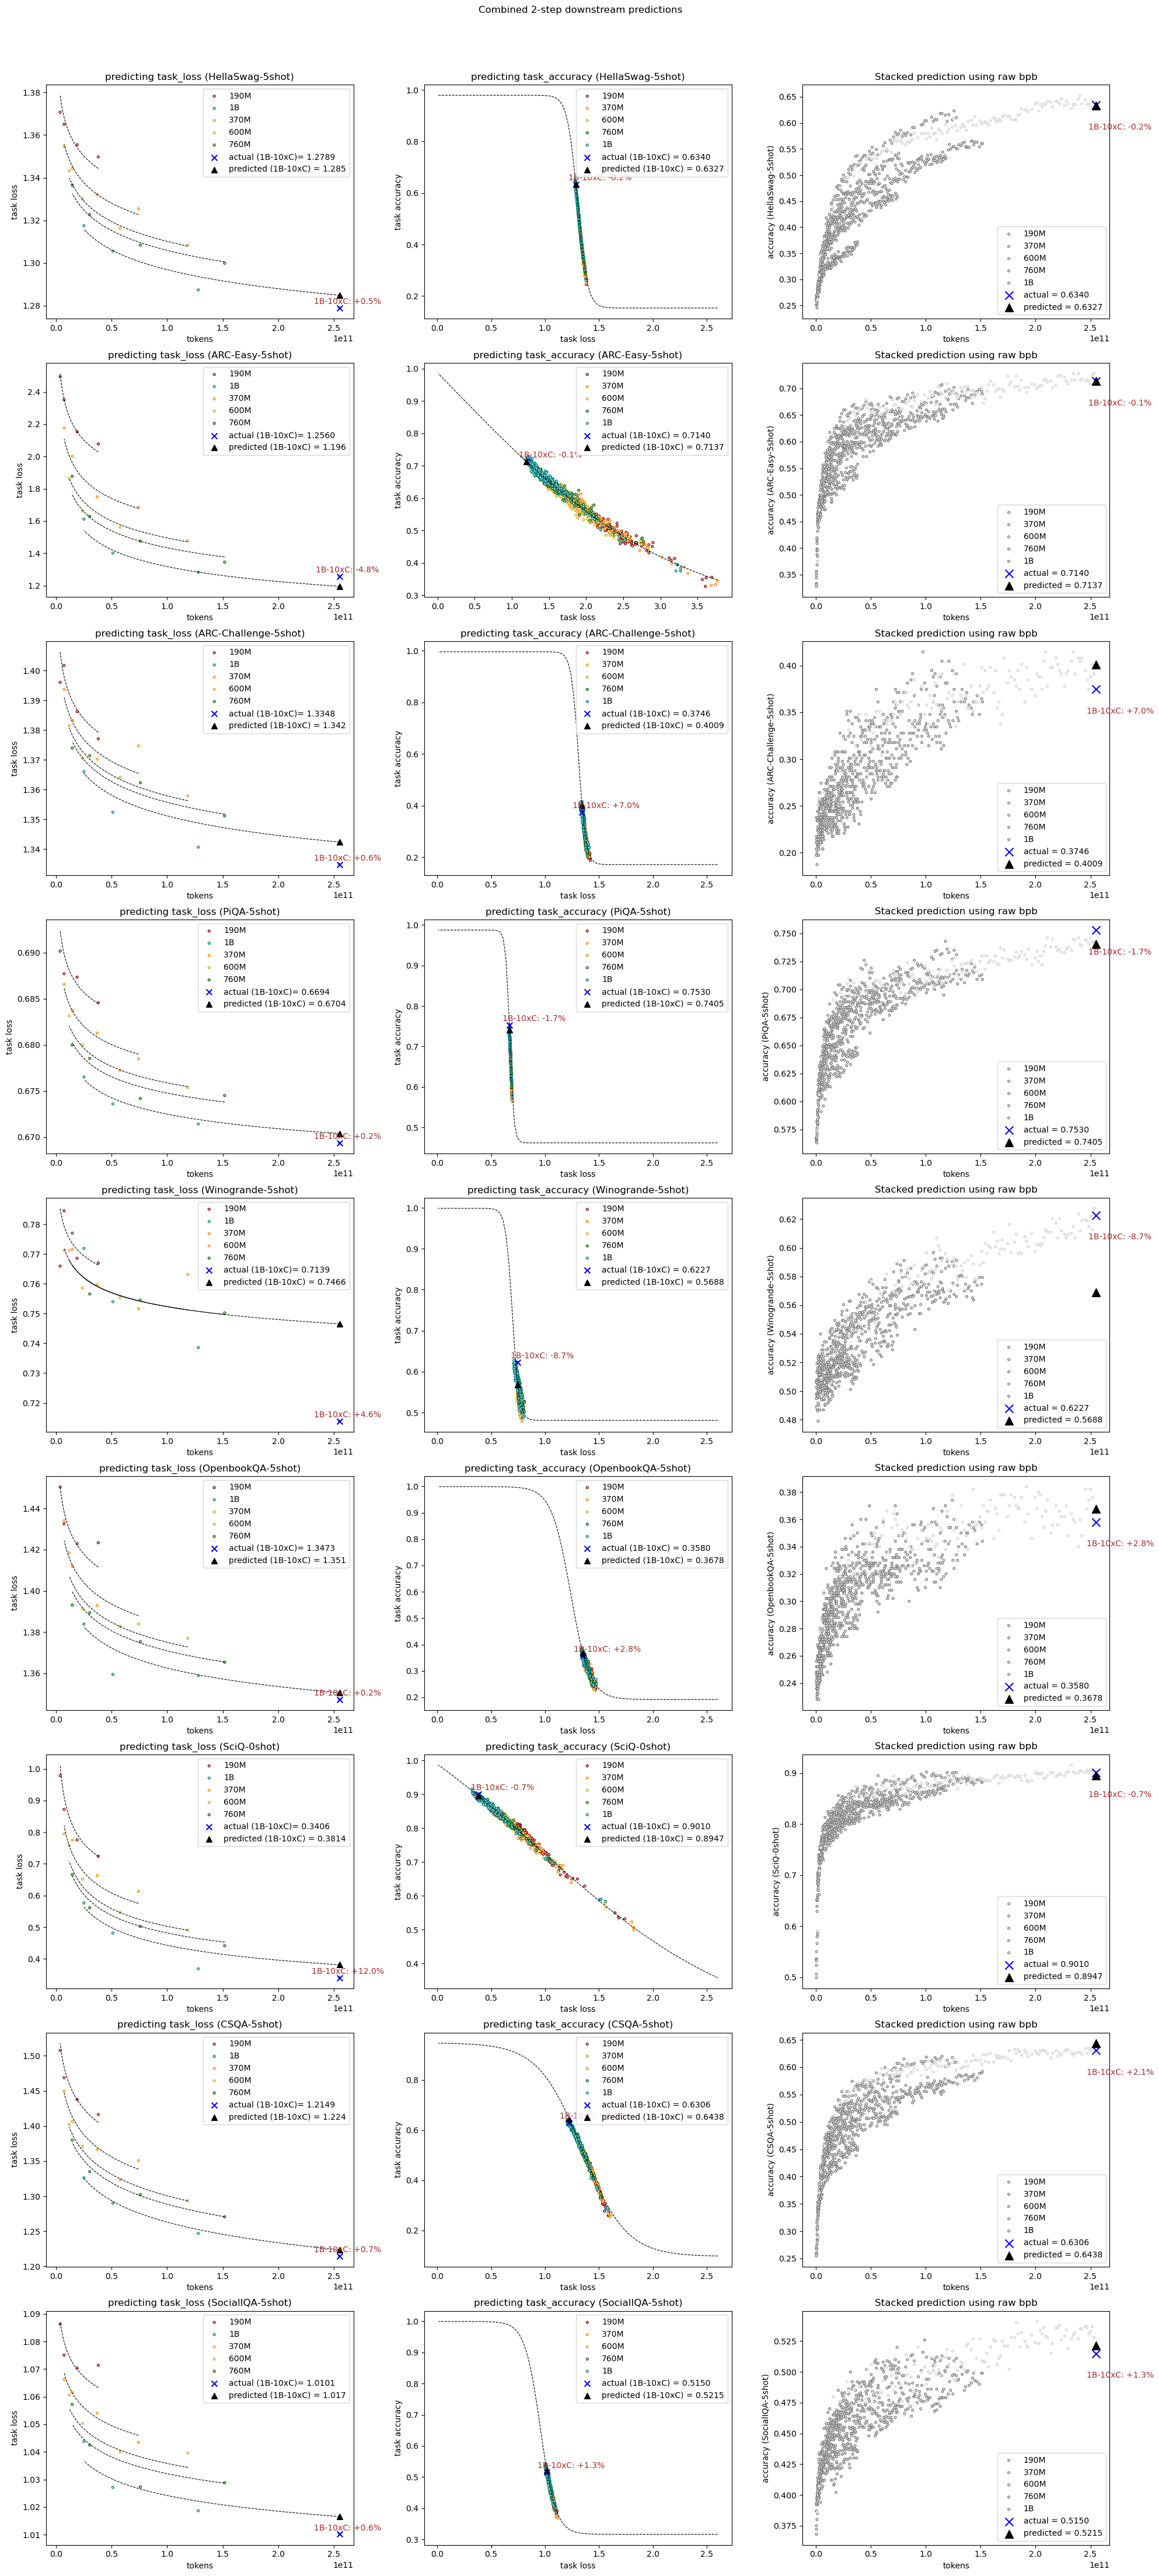

In [10]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    stacked_error[target] = {}

    for i, (task_name, task) in enumerate(tasks.items()):
        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'], negate=True)
        downstream_loss = get_all_data_by_name(configs, task['score'])

        df = get_dataframe(tokens, downstream_loss)

        step1_df = get_dataframe(tokens, bpb_loss)
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, coefficients = fit_step1(step1_df)

        do_plot = "1B-10xC" in configs
        if do_plot:
            plot_step1(
                step1_df,
                coefficients,
                axes[i][0],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )
        step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(bpb_loss, downstream_loss)

        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]

        step2_df, coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot:
            plot_step2(
                step2_df,
                coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )
        stacked_error[target][task_name] = get_predicted_error(step2_df)

        if do_plot:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)

fig.suptitle('Combined 2-step downstream predictions', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-1B-5xC.png", dpi=300)

In [12]:
def prettify(rel_error):
    return f"{rel_error * 100:+.1f}%"

mkdn = """| Task | Stacked error (1B-10xC) |\n| --- | --- |"""

for task in tasks:
    mkdn += f"\n| {task} |"
    for target in ["1B-10xC"]:
        mkdn += f"{prettify(stacked_error[target][task])} |"

mkdn += "\n| **Avg signed error** | "
for target in ["1B-10xC"]:
    mkdn += f"**{prettify(np.mean(list(stacked_error[target].values())))}** |"


mkdn += "\n| **Avg unsigned error** | "
for target in ["1B-10xC"]:
    mkdn += f"**{prettify(np.mean(np.abs(list(stacked_error[target].values()))))}** |"
print(mkdn)

| Task | Stacked error (1B-10xC) |
| --- | --- |
| HellaSwag-5shot |-0.2% |
| ARC-Easy-5shot |-0.1% |
| ARC-Challenge-5shot |+7.0% |
| PiQA-5shot |-1.7% |
| Winogrande-5shot |-8.7% |
| OpenbookQA-5shot |+2.8% |
| SciQ-0shot |-0.7% |
| CSQA-5shot |+2.1% |
| SocialIQA-5shot |+1.3% |
| **Avg signed error** | **+0.2%** |
| **Avg unsigned error** | **+2.7%** |


# Hard setting: only use runs that have less than 10x the flops of the target model

We should be able to predict using only 1/10th the number of flops.

In [13]:
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))

sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
for tup in sorted_by_flops:
    print(tup)

## I'm using generous upper-bounds here to find the nearest corresponding run

corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}
print()
print()
print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
for key, val in corresponding_flops_10x.items():
    print(f"{key} uses upto {val}")

('190M-1xC', 5.78262484353024)
('190M-2xC', 11.56524968706048)
('370M-1xC', 21.765149207014932)
('190M-5xC', 28.9131242176512)
('370M-2xC', 43.530298414029865)
('600M-1xC', 53.85819379339542)
('190M-10xC', 57.8262484353024)
('760M-1xC', 84.99363997969023)
('600M-2xC', 107.71638758679084)
('370M-5xC', 108.82574603507466)
('760M-2xC', 169.98727995938046)
('370M-10xC', 217.65149207014932)
('1B-1xC', 232.43283455771936)
('600M-5xC', 269.2909689669771)
('760M-5xC', 424.96819989845113)
('1B-2xC', 464.8656691154387)
('600M-10xC', 538.5819379339542)
('760M-10xC', 849.9363997969023)
('1B-5xC', 1162.1641727885967)
('1B-10xC', 2324.3283455771934)


Using generous upper-bounds to find nearest corresponding 10x less flops run
1B-10xC uses upto 1B-1xC


In [14]:
# tups = [(tup[0].split("-")[0], tup[0].split("-")[1], tup[1]) for tup in sorted_by_flops]

# length_colors = {
#     "1xC": "pink",
#     "2xC": "lightcoral",
#     "5xC": "rosybrown",
#     "10xC": "saddlebrown"
# }

# ladder_df = pd.DataFrame(tups, columns=["size", "length", "gflops"])
# ladder_df["color"] = ladder_df.apply(lambda x: color_map[x["size"]], axis=1)
# #ladder_df["color"] = ladder_df.apply(lambda x: length_colors[x["length"]], axis=1)
# ladder_df["label"] = ladder_df.apply(lambda x: f"{x['size']}-{x['length']}", axis=1)
# ladder_df["log_gflops"] = ladder_df.apply(lambda x: np.log(x['gflops']), axis=1)
# ladder_df["dot_size"] = ladder_df.apply(lambda x: 72 if x['size'] == '3B' else 36, axis=1)

# fig = plt.figure(figsize=(20, 5))
# ax = plt.gca()

# for label in ladder_df["size"].unique():
#     adf = ladder_df[ladder_df["size"]==label]
#     ax.scatter(adf["log_gflops"], adf["size"], color=adf["color"], s=adf["dot_size"], label=adf["label"])

# for _, row in ladder_df.iterrows():
#     ax.annotate(
#         f"{row['label']}",
#         (row['log_gflops'], row['size']),
#         textcoords="offset points",
#         xytext=(10, 5),
#         ha="center",
#         fontsize=8,
#         color="brown",
#     )

# y_loc = -40
# for key, val in corresponding_flops_10x.items():
#     row = ladder_df[ladder_df["label"] == val].iloc[0]
#     ax.axvline(x = row["log_gflops"], color=color_map["3B"], label = row["label"], linestyle='--')
#     ax.annotate(
#         f"used\nfor <--- \n{key}",
#         (row['log_gflops'], "3B"),
#         textcoords="offset points",
#         xytext=(-25, y_loc),
#         ha="center",
#         fontsize=9,
#         color=color_map["3B"],
#     )
#     if y_loc == -40:
#         y_loc = -20
#     else:
#         y_loc = -40

# ax.set_xlabel("Log GFlops")
# ax.set_ylabel("Model size")
# ax.set_title("Which models are used for learning prediction curves for the different 3B models (10x less GFlops)")
# plt.show()

In [15]:
all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:

        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"{WANDB_RESULTS}/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"{WANDB_RESULTS}/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": color_map[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"{WANDB_RESULTS}/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": color_map[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)


In [16]:
# for conf, val in all_configs[0].items():
#     print([path.split("/")[-1].strip(".csv") for path in val.paths])

# for conf, val in all_configs[1].items():
#     print([path.split("/")[-1].strip(".csv") for path in val.paths])

# for conf, val in all_configs[2].items():
#     print([path.split("/")[-1].strip(".csv") for path in val.paths])

### Raw bpb values

In [17]:
del all_configs[0]["1B"]

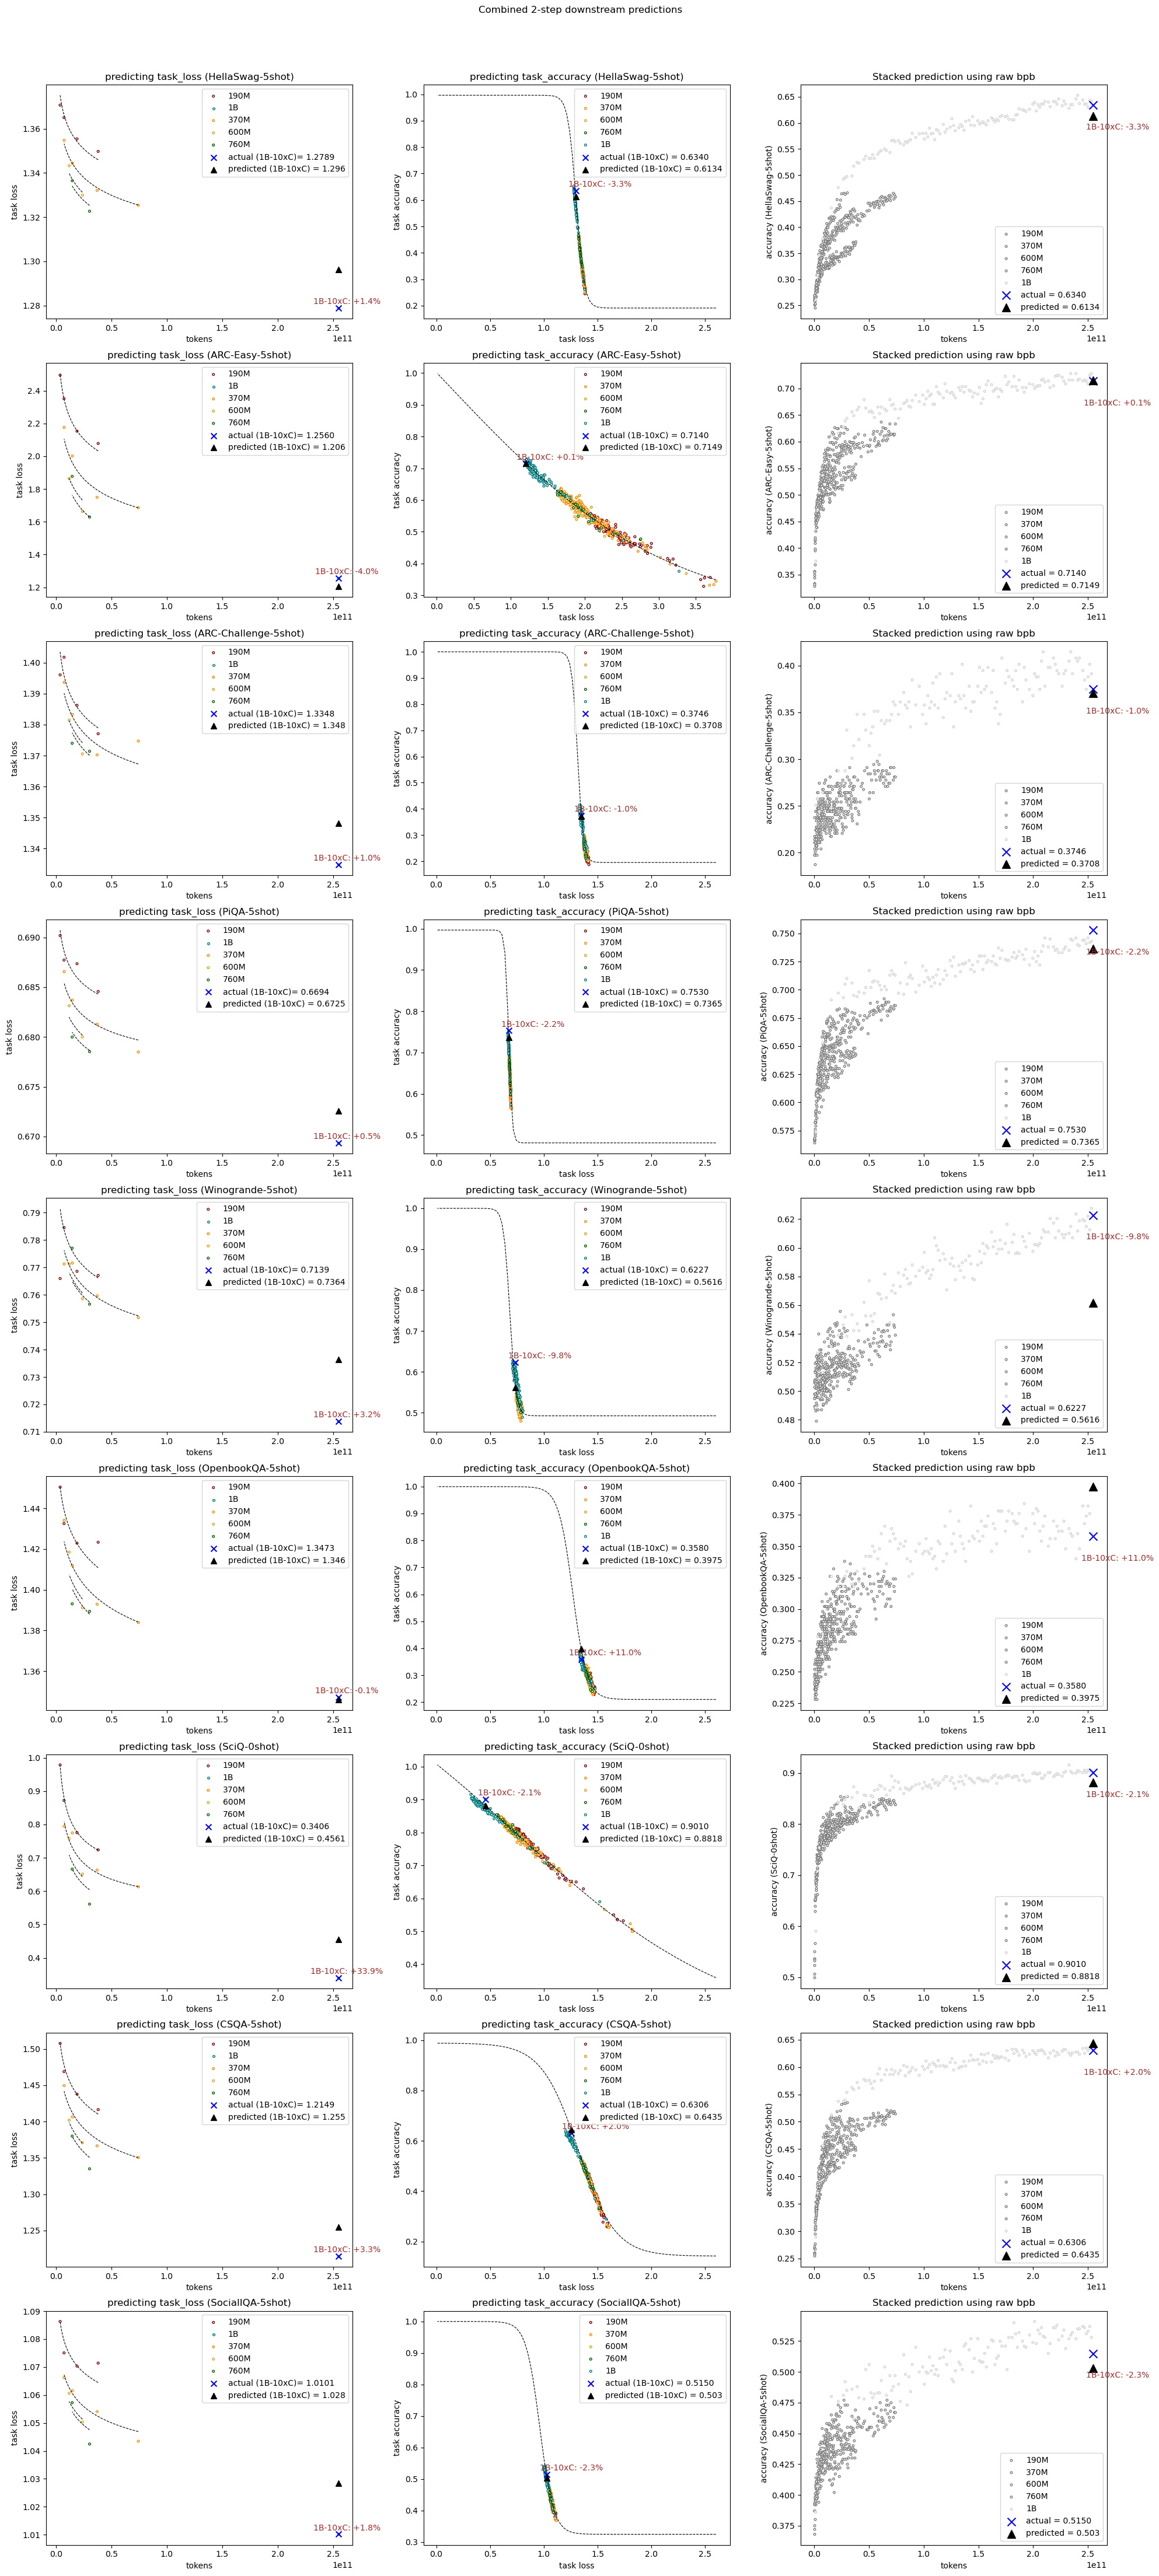

In [18]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    stacked_error[target] = {}

    for i, (task_name, task) in enumerate(tasks.items()):

        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'], negate=True)
        downstream_loss = get_all_data_by_name(configs, task['score'])

        df = get_dataframe(tokens, downstream_loss)

        step1_df = get_dataframe(tokens, bpb_loss)
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, coefficients = fit_step1(step1_df)

        # Only plot for the final prediction
        do_plot = "1B-10xC" in configs

        if do_plot:
            plot_step1(
                step1_df,
                coefficients,
                axes[i][0],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )

        step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(bpb_loss, downstream_loss)
        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]

        step2_df, coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot:
            plot_step2(
                step2_df,
                coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )

        stacked_error[target][task_name] = get_predicted_error(step2_df)

        if do_plot:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)


fig.suptitle('Combined 2-step downstream predictions', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-1B-5xC.png", dpi=300)

In [20]:
def prettify(rel_error):
    return f"{rel_error * 100:+.1f}%"

mkdn = """| Task | Stacked error (1B-10xC) |\n| --- | --- |"""

for task in tasks:
    mkdn += f"\n| {task} |"
    for target in ["1B-10xC"]:
        mkdn += f"{prettify(stacked_error[target][task])} |"

mkdn += "\n| **Avg signed error** | "
for target in ["1B-10xC"]:
    mkdn += f"**{prettify(np.mean(list(stacked_error[target].values())))}** |"


mkdn += "\n| **Avg unsigned error** | "
for target in ["1B-10xC"]:
    mkdn += f"**{prettify(np.mean(np.abs(list(stacked_error[target].values()))))}** |"
print(mkdn)

| Task | Stacked error (1B-10xC) |
| --- | --- |
| HellaSwag-5shot |-3.3% |
| ARC-Easy-5shot |+0.1% |
| ARC-Challenge-5shot |-1.0% |
| PiQA-5shot |-2.2% |
| Winogrande-5shot |-9.8% |
| OpenbookQA-5shot |+11.0% |
| SciQ-0shot |-2.1% |
| CSQA-5shot |+2.0% |
| SocialIQA-5shot |-2.3% |
| **Avg signed error** | **-0.8%** |
| **Avg unsigned error** | **+3.8%** |
